In [479]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

color_pal = sns.color_palette()

# Goal of the project : obtain the probability of the next event occuring on the TESLA Stocks

##### Disclaimer : It is not an easy task to forecast stocks because we cannot only rely on the historicity of the market. Indeed, World events, crises and spontaneous decisions make the task highly complex, and add an undeniable element of uncertainty to the stock forecasting process. However, historical datas remain a strong element for analysis and one can recognize some patterns on the market. These patterns do not take all factors into account, but they can serve as a reference point in certain situations where we need to take a stand.

##### Today, I am not going to look into patterns in particular. Instead, I want to look into the ways to use Markov chains to determine the probability of an event occuring on the google stocks.

## How does Markov chain work


A Markov chain is a mathematical model that represents a system that evolves from one state to another, randomly, but with a limited memory:

 

The Markov property defines that the future state depends only on the present state, not on previous states.

 

The system can move from a present state to a future state thanks to transition probabilities given by a transition matrix.

If we take the example with three states occuring : A, B and C, and we give to each of the states a probability to occur, then the transition matrix is modelled as follows:

in this example, only one of the three elements occurs each day

Then, for example, when the start state is A,  we have a 80% to get also state A tomorrow, 10% that B occurs and 10% that C occurs.

Things get interesting when we want to predict further ahead in time. For example, we want to get the probability that state A in occuring in two days from the current state A. In this contexte, we get 3 possibilities :

- A -> A -> A : 0.8 * 0.8 = 0.64

- A -> B -> A : 0.1 * 0.3 = 0.03

- A -> C -> A : 0.1 * 0.2 = 0.02

 

0.64 + 0.03 + 0.02 = 0.69 represents the probability that state A is occuring in tow days.

 

Actually, you can see that this computing correspond to the multiplication of the transition matrix by itself.




If we want the probability of the states occuring in a week from now, according to the markov chain, we have to multiply this matrix 7 times by itself.

### Concerning stocks market

##### I will suppose 5 different states in order to implement the markov chain in the google stocks analysis :

- consequent increase

- slight increase

- stagnation

- slight drop

- consequent drop

# Implementation in python

##### I am going to use the non-official yahoo finance API which is named yfinance to get the stock prices from TESLA. As it is an unoffcial API (this API scraps the html and json files of yahoo finance), this api is sensitive to changes on the yahoo site and this can lead to sudden errors. To avoid a potential error, I will save the stock prices found in a parquet file. (parquet format in order to save memory and conserve Dtypes of Series).

##### Before doing this, I'm going to retrieve a file containing the tickers for a number of companies as I'll need them to use the yfinance API. I can get such a csv file from the Nasdaq website at this address: https://www.nasdaq.com/market-activity/stocks/screener

In [480]:
def get_ticker(name: str):
    """ 
    Get the ticker of a company
    """
    tickers_list = pd.read_csv("Tickers_list.csv")
    tickers_list = tickers_list[["Symbol", "Name"]]
    tickers_list["Name"] = tickers_list["Name"].str.lower()
    return tickers_list.loc[tickers_list["Name"].str.contains(name)]

get_ticker("tesla")

,Symbol,Name
6285,TSLA,tesla inc. common stock


##### As the ticker of Tesla is TSLA. I use the yfinance API with this ticker to get the stock prices of Tesla for the max period.


In [481]:
def get_and_save(t: str):
    """
    Get the stocks using the yahoo finance API and save the DataFrame in a parquet file
    """
    ticker = yf.Ticker(t)
    df_stocks = ticker.history(period='max').to_parquet("TESLA_stocks.parquet")
    return pd.read_parquet("TESLA_stocks.parquet")

df = get_and_save("TSLA")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3752 entries, 2010-06-29 00:00:00-04:00 to 2025-05-28 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3752 non-null   float64
 1   High          3752 non-null   float64
 2   Low           3752 non-null   float64
 3   Close         3752 non-null   float64
 4   Volume        3752 non-null   int64  
 5   Dividends     3752 non-null   float64
 6   Stock Splits  3752 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 234.5 KB



### Dynamic visual representation of stocks price

In [482]:
px.line(df, df.index, df["Close"], title="TESLA stock prices")

In [483]:
def format_dataset(df) : 
    """ 
    Clean and format the dataset.
    """
    df = df.reset_index()
    df = df[["Date", "Close"]]
    df["Date"] = df["Date"].dt.strftime("%Y-%m-%d")
    df["Date"] = pd.to_datetime(df["Date"])
    return df

df = format_dataset(df)


### Define the probability of each state occuring on the google stocks (Most delicate part)

##### The probability displayed later on the transition matrix are going to highly rely on how we defined our 5 steps. 
It is the most delicate part to determine these states. The results can vary a lot depending on if a variation of 5% is considered as a slight increase or a big rise. 

For my part, I will define my states as the following : 

- consequent drop: -8% or lower

- slight drop : from -8% to -0.5%

- stagnation : from -0.5% to 0.5%

- slight increase : from 0.5% to 8%

- consequent increase : 8% or above


In [484]:
# States creation function

def assign_states(df, target):
    """
    Creation function of the stats consequent increase, slight increase, stagnation, slight drop, consequent drop
    """
    growth = df[target].pct_change()
    df["state"] = "défault" # by default state
    df.loc[growth <= -0.08 , "state"] = 0  # consequent drop
    df.loc[(growth > -0.08) & (growth <= -0.005), "state"] = 1  # slight drop
    df.loc[(growth > -0.005) & (growth < 0.005), "state"] = 2  # stagnation
    df.loc[(growth >= 0.005) & (growth < 0.08), "state"] = 3  # slight increase
    df.loc[growth >= 0.08, "state"] = 4  # consequent increase
    df = df.drop(df[df["state"] == "défault"].index) # Supress the first NaN value due to .pct_change()
    df["state"] = df["state"].astype('int8')
    return df


In [485]:
# Creation of the transition matrix

def transition_matrix(states, n_states = 5) : 
    """
    Create the transition matrice for the Markov chain
    """
    matrix = np.zeros((n_states, n_states))
    for (i, j) in zip(states[:-1], states[1:]) :
        matrix[i, j] += 1
    matrix = matrix / matrix.sum(axis=1, keepdims=True)

    return pd.DataFrame(data = matrix, index = ["consequent_drop", "slight_drop", "stagnation", "slight_increase", "consequent_increase"], columns=["consequent_drop", "slight_drop", "stagnation", "slight_increase", "consequent_increase"])

# Apply the functions 
df = assign_states(df, target="Close")
tm = transition_matrix(df["state"], n_states=5)

In [486]:
tm

,consequent_drop,slight_drop,stagnation,slight_increase,consequent_increase
consequent_drop,0.016129,0.354839,0.112903,0.419355,0.096774
slight_drop,0.024028,0.368198,0.164664,0.418375,0.024735
stagnation,0.012103,0.394856,0.183056,0.396369,0.013616
slight_increase,0.011834,0.377383,0.187377,0.401709,0.021696
consequent_increase,0.010989,0.417582,0.153846,0.329670,0.087912


# Get the current state and the probabilities for the future state

In [487]:
def Display_probs_next_move(df, transition_df):
    """
    Get the current state and its transition probability.
    """
    states = ["consequent_drop", "slight_drop", "stagnation", "slight_increase", "consequent_increase"]
    for i, state in zip(range(5), states):
        if df["state"].iloc[-1] == i:    
            next_probs = pd.DataFrame(data= transition_df.to_numpy()[i, :]).T.rename(columns={0:"consequent_drop", 1:"slight_drop", 2: "stagnation", 3: "slight_increase", 4: "consequent_increase"})
            current_state = pd.DataFrame({"current state": state}, index=[0])
            return pd.concat([current_state, next_probs], axis=1)


next_prob = Display_probs_next_move(df, tm)
next_prob

,current state,consequent_drop,slight_drop,stagnation,slight_increase,consequent_increase
0,slight_drop,0.024028,0.368198,0.164664,0.418375,0.024735


# Get the number of times of each states historically

In [488]:
def historical_number_of_states(df, target):
    """ 
    Get the historical number of states
    """
    states_number = pd.DataFrame(data = df[target].value_counts()).sort_values(by=target, ascending=True).reset_index()
    states_number[target] = states_number[target].astype('object')

    for i, j in zip(range(5), ["consequent_drop", "slight_drop", "stagnation", "slight_increase", "consequent_increase"]):
        states_number.loc[states_number[target] == i, target] = j
    states_number = states_number.set_index(target)

    return states_number

# Apply the function 
states_number = historical_number_of_states(df, target="state")
states_number


,count
state,
consequent_drop,62
slight_drop,1416
stagnation,661
slight_increase,1521
consequent_increase,91


# Get probabilities of event occuring more than just the next time

##### To get that, we need to reach stationary distribution of the markov chains. The Stationary distribution of the Markov chain is when the system forgets its starting point and no matter the number of times the transition matrix is multiplicated, the output will always be the same. In Stocks prediction, the stationarity distribution of the Markov Chains corresponds to the long-term equilibrium. Stationary distribution is given by the stationary transition matrix. 

##### Let's calculate the stationary transition matrix and determine from how many multiplications this matrix does not evolve anymore


# Compute the stationary matrix and the number of iterations needed to reach it


In [489]:
def reach_stable_states(transition_df):
    """
    Computes at which iteration the stationary matrix is reached.
    Returns the number of iterations needed and the stationary matrix itself
    """
    previous = transition_df.to_numpy()
    base = transition_df.to_numpy()
    count = 0
    while True:
        current = previous.dot(base)
        count += 1
        if np.allclose(current, previous, atol=1e-5) :
            break
        previous = current
    return count, pd.DataFrame(data=current, index=transition_df.index, columns=transition_df.columns)


iterations, stationary_matrix = reach_stable_states(tm)

print(f"Matrix convergence in {iterations} iterations")
print("Stationary Matrix:")
print(stationary_matrix)

Matrix convergence in 5 iterations
Stationary Matrix:
                     consequent_drop  slight_drop  stagnation  \
consequent_drop             0.016536     0.377593    0.175995   
slight_drop                 0.016536     0.377593    0.175995   
stagnation                  0.016536     0.377593    0.175995   
slight_increase             0.016536     0.377593    0.175995   
consequent_increase         0.016536     0.377593    0.175995   

                     slight_increase  consequent_increase  
consequent_drop             0.405605              0.02427  
slight_drop                 0.405606              0.02427  
stagnation                  0.405606              0.02427  
slight_increase             0.405606              0.02427  
consequent_increase         0.405605              0.02427  


##### According to the memoryless property of the markov chains, the probability on the market are the following. 

In [490]:
next_prob_long_term = Display_probs_next_move(df, stationary_matrix)
next_prob_long_term.drop("current state", axis=1)

,consequent_drop,slight_drop,stagnation,slight_increase,consequent_increase
0,0.016536,0.377593,0.175995,0.405606,0.02427


### Visualize the two transition probability matrix (for the next event and at the equilibrium of the market)

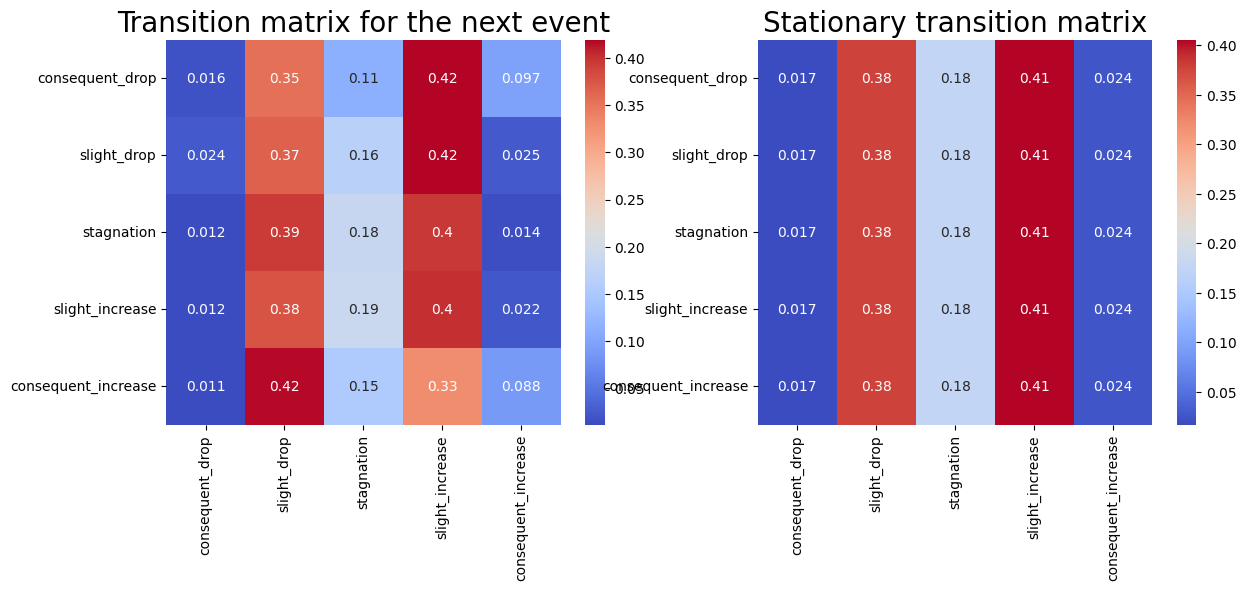

In [491]:
def view_matrix(transition_df, stationary_transition_df):
    """
    Display both the transition matrix for the next event and the transition matrix when the market is considered at its equilibirum
    """
    plt.figure(figsize=(14, 5))
    for (i, matrix, title) in zip(range(1, 3), [transition_df, stationary_transition_df], ["Transition matrix for the next event", "Stationary transition matrix"]):
        plt.subplot(1, 2, i)
        sns.heatmap(data=matrix, cmap="coolwarm", annot=True)
        plt.title(title, fontsize=20)
    return plt.show()

view_matrix(tm, stationary_matrix)

# Installation of an automated pipeline

In [492]:
from IPython.display import display

def stocks_markov(company: str):
    """
    Automated pipeline which displays the Markov chains for the chosen company.
    Displays the name of the company, the DataFrame, current state's transition probabilities, and the stationary matrix.
    """
    df_ticker = get_ticker(company)
    df_ticker = df_ticker["Symbol"].iloc[0]
    df = get_and_save(df_ticker)
    df = format_dataset(df)
    df = assign_states(df, target="Close")

    tm = transition_matrix(df["state"], n_states=5)
    next_prob = Display_probs_next_move(df, tm)
    states_number = historical_number_of_states(df, target="state")
    iterations, stationary_matrix = reach_stable_states(tm)

    print(f"Overview of {company}'s stock prices:")
    display(df)
    print("Current state: ")
    display(next_prob["current state"].iloc[0])
    print("Number of states on this market historically")
    display(states_number)
    display(view_matrix(tm, stationary_matrix))

    return None



Overview of apple's stock prices:


,Date,Close,state
1,1980-12-15,0.093453,1
2,1980-12-16,0.086594,1
3,1980-12-17,0.088737,3
4,1980-12-18,0.091310,3
5,1980-12-19,0.096882,3
...,...,...,...
11200,2025-05-21,202.089996,1
11201,2025-05-22,201.360001,2
11202,2025-05-23,195.270004,1
11203,2025-05-27,200.210007,3


Current state: 


'stagnation'

Number of states on this market historically


,count
state,
consequent_drop,62
slight_drop,4194
stagnation,2338
slight_increase,4505
consequent_increase,105


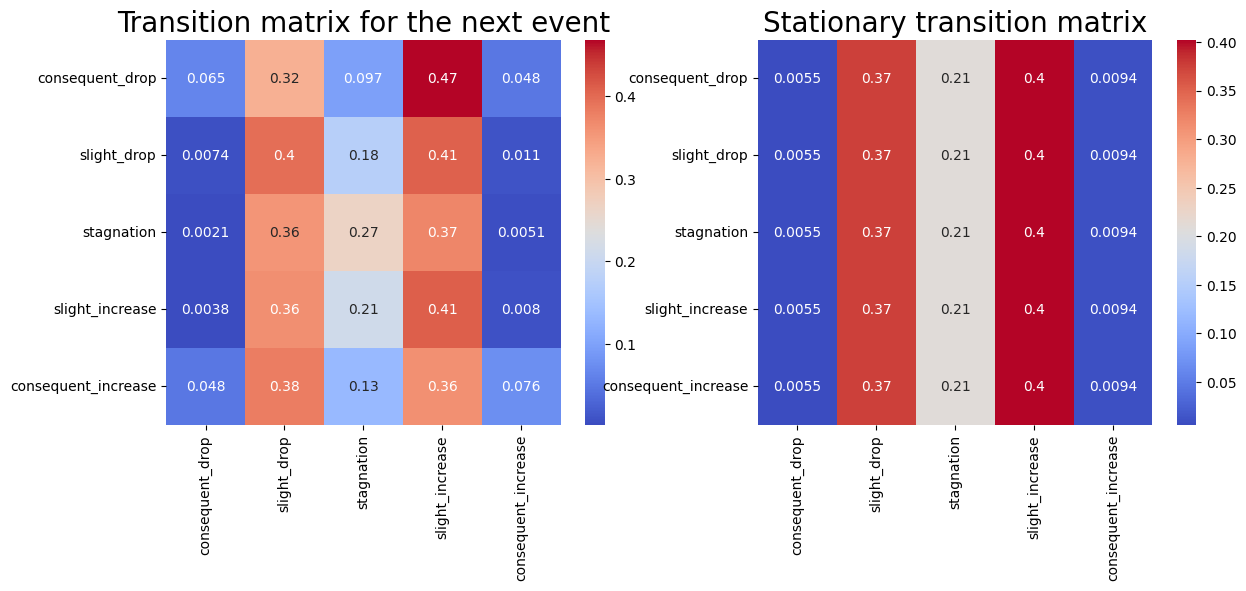

None

In [493]:
stocks_markov("apple")


Overview of microsoft's stock prices:


,Date,Close,state
1,1986-03-14,0.061726,3
2,1986-03-17,0.062791,3
3,1986-03-18,0.061194,1
4,1986-03-19,0.060130,1
5,1986-03-20,0.058533,1
...,...,...,...
9874,2025-05-21,452.570007,1
9875,2025-05-22,454.859985,3
9876,2025-05-23,450.179993,1
9877,2025-05-27,460.690002,3


Current state: 


'slight_drop'

Number of states on this market historically


,count
state,
consequent_drop,25
slight_drop,3363
stagnation,2728
slight_increase,3725
consequent_increase,37


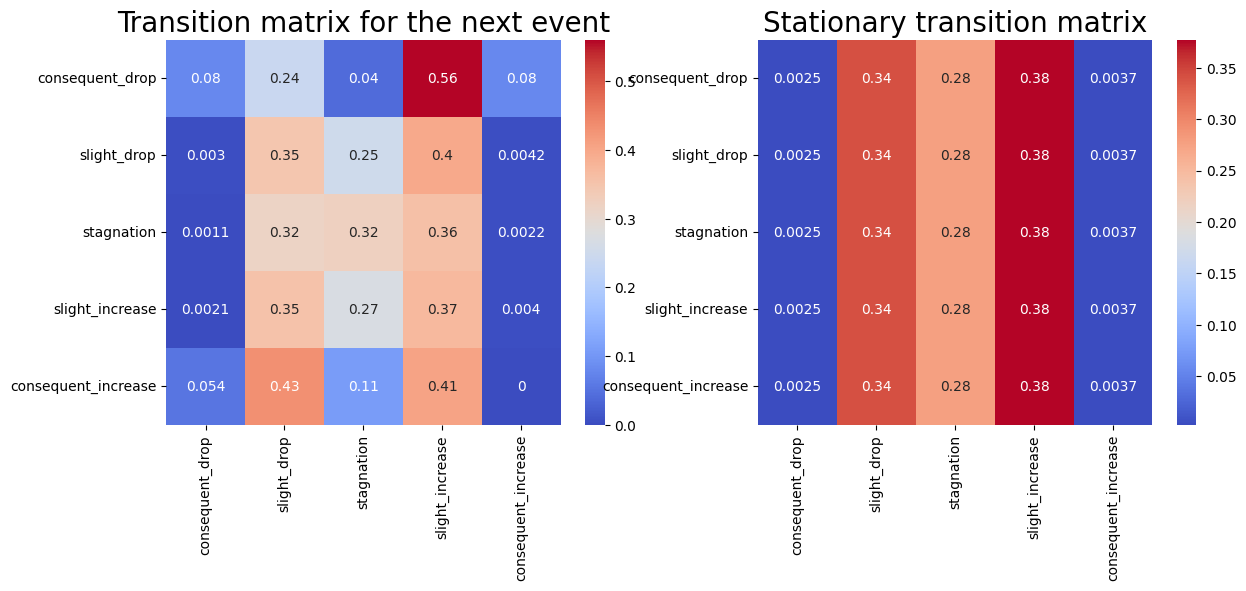

None

In [494]:
stocks_markov("microsoft")